In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/Shared drives/SI671_final_project/SI671_final_project/Data_file'

Mounted at /content/drive
/content/drive/My Drive/SI 671/project


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import DataFrame 
import nltk

from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from scipy.spatial.distance import cosine
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import re
import string
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import mean_squared_error

In [ ]:
df = pd.read_json('Grocery_and_Gourmet_Food_5.json', lines=True)
print(df.columns)
print(df.shape)

Index(['overall', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote',
       'style', 'image'],
      dtype='object')
(1143860, 12)


In [ ]:
count = df.groupby("asin", as_index=False).count()
mean = df.groupby("asin", as_index=False).mean()

dfMerged = pd.merge(df, count, how='right', on=['asin'])
dfMerged

,overall_x,verified_x,reviewTime_x,reviewerID_x,asin,reviewerName_x,reviewText_x,summary_x,unixReviewTime_x,vote_x,style_x,image_x,overall_y,verified_y,reviewTime_y,reviewerID_y,reviewerName_y,reviewText_y,summary_y,unixReviewTime_y,vote_y,style_y,image_y
0,5,True,"04 29, 2012",A1J205ZK25TZ6W,4639725043,kez panel project,I make the best brewed iced tea with this yell...,Best for brewed iced tea.,1335657600,8,NaN,NaN,30,30,30,30,30,30,30,30,6,0,0
1,3,True,"04 11, 2008",ACOICLIJQYECU,4639725043,N D,I have recently started drinking hot tea again...,Not Bad for iced Tea,1207872000,9,NaN,NaN,30,30,30,30,30,30,30,30,6,0,0
2,5,True,"03 15, 2017",A29RCQA5G0B1BA,4639725043,Edward Pendleton,I like pretty much all of Lipton's tea... I ju...,A Great Cuppa...!,1489536000,NaN,NaN,NaN,30,30,30,30,30,30,30,30,6,0,0
3,5,True,"03 4, 2017",A34KF6WKUMO0G5,4639725043,Kindle Customer,I was watching a youtube video about buying te...,Strong for this American,1488585600,NaN,NaN,NaN,30,30,30,30,30,30,30,30,6,0,0
4,3,True,"02 27, 2017",A2AW00VDYVKKKK,4639725043,Lou S. Hegwer,"it was ok, but it didn't taste like the Lipton...",not the same,1488153600,NaN,NaN,NaN,30,30,30,30,30,30,30,30,6,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1143855,5,True,"09 8, 2017",A223YRQH2Z5T1D,B01HJF6FRA,flint5292,"As a new vegan, it is sometimes difficult to r...","As a new vegan, it is sometimes difficult to ...",1504828800,4,NaN,NaN,6,6,6,6,6,6,6,6,4,0,0
1143856,5,True,"08 4, 2017",A38GDA4TB9EILT,B01HJF6FRA,Moriah Bolyard,The best thing ever is ordering a product you ...,The best thing ever is ordering a product you ...,1501804800,3,NaN,NaN,6,6,6,6,6,6,6,6,4,0,0
1143857,5,True,"07 4, 2017",A2025PN7HDC5BO,B01HJF6FRA,M.C,I used to love ranch before I became vegan. It...,Just what the vegan ordered!,1499126400,5,NaN,NaN,6,6,6,6,6,6,6,6,4,0,0
1143858,5,True,"06 7, 2017",A1NY7XWC7EPQOA,B01HJF6FRA,Greensboro,I cannot have dairy nor gluten. This is as cl...,This is as close to Ranch as I will ever be ab...,1496793600,2,NaN,NaN,6,6,6,6,6,6,6,6,4,0,0


In [ ]:
dfMerged["totalReviewers"] = dfMerged["reviewerID_y"]
dfMerged["overallScore"] = dfMerged["overall_x"]
dfMerged["summaryReview"] = dfMerged["summary_x"]

dfNew = dfMerged[['asin','summaryReview','overallScore',"totalReviewers"]]

In [ ]:
dfMerged = dfMerged.sort_values(by='totalReviewers', ascending=False)
dfCount = dfMerged[dfMerged.totalReviewers >= 100]
dfCount

,overall_x,verified_x,reviewTime_x,reviewerID_x,asin,reviewerName_x,reviewText_x,summary_x,unixReviewTime_x,vote_x,style_x,image_x,overall_y,verified_y,reviewTime_y,reviewerID_y,reviewerName_y,reviewText_y,summary_y,unixReviewTime_y,vote_y,style_y,image_y,totalReviewers,overallScore,summaryReview
754787,5,True,"06 18, 2014",A1MV9HIBBOO7G0,B00BUKL666,moll,I really loved these things...almost too much....,Good quality chocolate...rare for a snack bar,1403049600,NaN,NaN,NaN,7387,7387,7387,7387,7387,7383,7387,7387,190,0,20,7387,5,Good quality chocolate...rare for a snack bar
750257,3,True,"02 23, 2017",A1751UDRM42OAM,B00BUKL666,Barry S.,These are great when fresh.,Really good when fresh.,1487808000,NaN,NaN,NaN,7387,7387,7387,7387,7387,7383,7387,7387,190,0,20,7387,3,Really good when fresh.
750251,5,True,"02 26, 2017",A1IORC5L4N35A6,B00BUKL666,Ann,Good but cheaper at walmart,Five Stars,1488067200,NaN,NaN,NaN,7387,7387,7387,7387,7387,7383,7387,7387,190,0,20,7387,5,Five Stars
750252,4,True,"02 25, 2017",A17YQ40RH217RT,B00BUKL666,RealPerson,"Nephew loves these bars, not cheap but good.",Great to send in care package,1487980800,NaN,NaN,NaN,7387,7387,7387,7387,7387,7383,7387,7387,190,0,20,7387,4,Great to send in care package
750253,4,True,"02 25, 2017",AYEXJTSYHCRBK,B00BUKL666,Big D,very good snack,Healthy and Delicious,1487980800,NaN,NaN,NaN,7387,7387,7387,7387,7387,7383,7387,7387,190,0,20,7387,4,Healthy and Delicious
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525824,3,True,"12 21, 2015",A2XKFPXLI8MMD3,B004N8LMFM,Dezi,eh.. everything has the same flavor....,Three Stars,1450656000,NaN,{'Size:': ' 1Pack'},NaN,100,100,100,100,100,100,100,100,9,97,4,100,3,Three Stars
525827,4,True,"12 13, 2015",A1W28NYD3TYNL,B004N8LMFM,T. M. Crane,"Bought these kits: ice cream, hamburger, dough...",Rated by real kids,1449964800,NaN,{'Size:': ' 1Pack'},NaN,100,100,100,100,100,100,100,100,9,97,4,100,4,Rated by real kids
442655,5,True,"01 20, 2014",A1JI92BJRNOKYN,B002UGMH9Y,Amazon Customer,I purchased this to try for the low glycemic i...,Enjoy,1390176000,NaN,{'Size:': ' 1 Pound (Pack of 6)'},NaN,100,100,100,100,100,100,100,100,18,100,1,100,5,Enjoy
924529,5,True,"04 2, 2017",A30J2T00HG0J5M,B00K6JEON4,Kalani,"No smell, no taste, gelatin comes out consiste...",The best,1491091200,2,{'Size:': ' 32 oz'},NaN,100,100,100,100,100,100,100,100,40,100,2,100,5,The best


In [ ]:
dfProductReview = df.groupby("asin", as_index=False).mean()
ProductReviewSummary = dfCount.groupby("asin")["summaryReview"].apply(list)
ProductReviewSummary = pd.DataFrame(ProductReviewSummary)
ProductReviewSummary.to_csv("ProductReviewSummary.csv")

In [ ]:
dfProductReview

,asin,overall,verified,unixReviewTime
0,4639725043,4.200000,0.966667,1.421277e+09
1,4639725183,4.833333,1.000000,1.436609e+09
2,5463213682,4.888889,1.000000,1.443235e+09
3,9742356831,4.552083,0.822917,1.436860e+09
4,B00004S1C5,4.000000,0.928571,1.351160e+09
...,...,...,...,...
41315,B01HJ2OFYI,4.416667,1.000000,1.508789e+09
41316,B01HJ4FWGG,4.444444,0.944444,1.506994e+09
41317,B01HJ7QPKU,4.250000,0.250000,1.473584e+09
41318,B01HJCUNOO,4.400000,0.900000,1.490616e+09


In [ ]:
df3 = pd.read_csv("ProductReviewSummary.csv")
df3 = pd.merge(df3, dfProductReview, on="asin", how='inner')

In [ ]:
df3 = df3[['asin','summaryReview','overall']]

In [ ]:
#function for tokenizing summary
regEx = re.compile('[^a-z]+')
def cleanReviews(reviewText):
    reviewText = reviewText.lower()
    reviewText = regEx.sub(' ', reviewText).strip()
    return reviewText

In [ ]:
#reset index and drop duplicate rows
df3["summaryClean"] = df3["summaryReview"].apply(cleanReviews)
df3 = df3.drop_duplicates(['overall'], keep='last')
df3 = df3.reset_index()

In [ ]:
reviews = df3["summaryClean"] 
countVector = CountVectorizer(max_features = 300, stop_words='english') 
transformedReviews = countVector.fit_transform(reviews) 

dfReviews = DataFrame(transformedReviews.A, columns=countVector.get_feature_names())
dfReviews = dfReviews.astype(int)

In [ ]:
dfReviews.to_csv("dfReviews.csv")

In [ ]:
# First let's create a dataset called X
X = np.array(dfReviews)
 # create train and test
tpercent = 0.9
tsize = int(np.floor(tpercent * len(dfReviews)))
dfReviews_train = X[:tsize]
dfReviews_test = X[tsize:]
#len of train and test
lentrain = len(dfReviews_train)
lentest = len(dfReviews_test)

In [ ]:
print(lentrain)
print(lentest)

1463
163


In [ ]:
neighbor = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(dfReviews_train)

# Let's find the k-neighbors of each point in object X. To do that we call the kneighbors() function on object X.
distances, indices = neighbor.kneighbors(dfReviews_train)

In [ ]:
for i in range(lentest):
    a = neighbor.kneighbors([dfReviews_test[i]])
    related_product_list = a[1]

    first_related_product = [item[0] for item in related_product_list]
    first_related_product = str(first_related_product).strip('[]')
    first_related_product = int(first_related_product)
    second_related_product = [item[1] for item in related_product_list]
    second_related_product = str(second_related_product).strip('[]')
    second_related_product = int(second_related_product)
    
    print ("Based on product reviews, for ", df3["asin"][lentrain + i] ," average rating is ",df3["overall"][lentrain + i])
    print ("The first similar product is ", df3["asin"][first_related_product] ," average rating is ",df3["overall"][first_related_product])
    print ("The second similar product is ", df3["asin"][second_related_product] ," average rating is ",df3["overall"][second_related_product])
    print ("-----------------------------------------------------------")

Based on product reviews, for  B00R06N59K  average rating is  4.134228187919463
The first similar product is  B00QEMUPI0  average rating is  4.063063063063063
The second similar product is  B004YTV5S4  average rating is  4.718446601941747
-----------------------------------------------------------
Based on product reviews, for  B00R0OB7DI  average rating is  4.745098039215686
The first similar product is  B000F9XBIE  average rating is  4.566666666666666
The second similar product is  B004K51SJS  average rating is  4.515625
-----------------------------------------------------------
Based on product reviews, for  B00R7PWK7W  average rating is  4.568644818423383
The first similar product is  B00KSN9TME  average rating is  4.583996966249526
The second similar product is  B000U0OUP6  average rating is  4.55859375
-----------------------------------------------------------
Based on product reviews, for  B00RH6KETM  average rating is  4.775193798449612
The first similar product is  B001VNEIC

In [ ]:
print ("Based on product reviews, for ", df3["asin"][200] ," average rating is ",df3["overall"][200])
print ("The first similar product is ", df3["asin"][first_related_product] ," average rating is ",df3["overall"][first_related_product])
print ("The second similar product is ", df3["asin"][second_related_product] ," average rating is ",df3["overall"][second_related_product])
print ("-----------------------------------------------------------")

Based on product reviews, for  B000HVX6NK  average rating is  4.222222222222222
The first similar product is  B000JMAVYO  average rating is  4.578703703703703
The second similar product is  B0000DHXGL  average rating is  4.354515050167224
-----------------------------------------------------------


User K=3,TRAIN:TEST=9:1

In [ ]:
df5_train_target = df3["overall"][:lentrain]
df5_test_target = df3["overall"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)

n_neighbors = 3
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(dfReviews_train, df5_train_target)
knnpreds_test = knnclf.predict(dfReviews_test)

print(classification_report(df5_test_target, knnpreds_test))

              precision    recall  f1-score   support

           3       1.00      0.27      0.43        11
           4       0.95      1.00      0.97       152

    accuracy                           0.95       163
   macro avg       0.97      0.64      0.70       163
weighted avg       0.95      0.95      0.94       163



In [ ]:
print(accuracy_score(df5_test_target, knnpreds_test))

0.950920245398773


In [ ]:
print(mean_squared_error(df5_test_target, knnpreds_test))

0.049079754601226995


In [ ]:
neighbor = NearestNeighbors(n_neighbors=3, algorithm='kd_tree').fit(dfReviews_train)

# Let's find the k-neighbors of each point in object X. To do that we call the kneighbors() function on object X.
distances, indices = neighbor.kneighbors(dfReviews_train)
df5_train_target = df3["overall"][:lentrain]
df5_test_target = df3["overall"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)
n_neighbors = 3
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(dfReviews_train, df5_train_target)
knnpreds_test = knnclf.predict(dfReviews_test)

print(classification_report(df5_test_target, knnpreds_test))
print ("Accuracy: ",accuracy_score(df5_test_target, knnpreds_test))
print("MSE: ",mean_squared_error(df5_test_target, knnpreds_test))

              precision    recall  f1-score   support

           3       1.00      0.27      0.43        11
           4       0.95      1.00      0.97       152

    accuracy                           0.95       163
   macro avg       0.97      0.64      0.70       163
weighted avg       0.95      0.95      0.94       163

Accuracy:  0.950920245398773
MSE:  0.049079754601226995


In [ ]:
df5_train_target = df3["overall"][:lentrain]
df5_test_target = df3["overall"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)

n_neighbors = 5
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(dfReviews_train, df5_train_target)
knnpreds_test = knnclf.predict(dfReviews_test)

print(classification_report(df5_test_target, knnpreds_test))

              precision    recall  f1-score   support

           3       1.00      0.18      0.31        11
           4       0.94      1.00      0.97       152

    accuracy                           0.94       163
   macro avg       0.97      0.59      0.64       163
weighted avg       0.95      0.94      0.93       163



In [ ]:
print(accuracy_score(df5_test_target, knnpreds_test))
print(mean_squared_error(df5_test_target, knnpreds_test))

0.9447852760736196
0.05521472392638037


Predicting reviews with 85, 15 train, test split and k = 5

In [ ]:
X = np.array(dfReviews)
 # create train and test
tpercent = 0.7
tsize = int(np.floor(tpercent * len(dfReviews)))
dfReviews_train = X[:tsize]
dfReviews_test = X[tsize:]
#len of train and test
lentrain = len(dfReviews_train)
lentest = len(dfReviews_test)

In [ ]:
# Next we will instantiate a nearest neighbor object, and call it nbrs. Then we will fit it to dataset X.
neighbor = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(dfReviews_train)

# Let's find the k-neighbors of each point in object X. To do that we call the kneighbors() function on object X.
distances, indices = neighbor.kneighbors(dfReviews_train)

In [ ]:
for i in range(lentest):
    a = neighbor.kneighbors([dfReviews_test[i]])
    related_product_list = a[1]

    first_related_product = [item[0] for item in related_product_list]
    first_related_product = str(first_related_product).strip('[]')
    first_related_product = int(first_related_product)
    second_related_product = [item[1] for item in related_product_list]
    second_related_product = str(second_related_product).strip('[]')
    second_related_product = int(second_related_product)
    
    print ("Based on product reviews, for ", df3["asin"][lentrain + i] ," average rating is ",df3["overall"][lentrain + i])
    print ("The first similar product is ", df3["asin"][first_related_product] ," average rating is ",df3["overall"][first_related_product])
    print ("The second similar product is ", df3["asin"][second_related_product] ," average rating is ",df3["overall"][second_related_product])
    print ("-----------------------------------------------------------")

Based on product reviews, for  B00B1UE4GY  average rating is  3.9591836734693877
The first similar product is  B006V3TMUO  average rating is  4.182608695652174
The second similar product is  B001AW9PSA  average rating is  4.12781954887218
-----------------------------------------------------------
Based on product reviews, for  B00B28Z9IC  average rating is  4.712574850299402
The first similar product is  B003SO9QZA  average rating is  4.741071428571429
The second similar product is  B001LQWO8I  average rating is  4.589743589743589
-----------------------------------------------------------
Based on product reviews, for  B00B2JUBJS  average rating is  3.843137254901961
The first similar product is  B004ENHZVQ  average rating is  4.055555555555555
The second similar product is  B006V3TMUO  average rating is  4.182608695652174
-----------------------------------------------------------
Based on product reviews, for  B00B42NQC2  average rating is  4.741935483870968
The first similar produ

In [ ]:
df5_train_target = df3["overall"][:lentrain]
df5_test_target = df3["overall"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)

n_neighbors = 5
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(dfReviews_train, df5_train_target)
knnpreds_test = knnclf.predict(dfReviews_test)
#print (knnpreds_test)

print(classification_report(df5_test_target, knnpreds_test))

              precision    recall  f1-score   support

           3       1.00      0.07      0.12        30
           4       0.94      1.00      0.97       458

    accuracy                           0.94       488
   macro avg       0.97      0.53      0.55       488
weighted avg       0.95      0.94      0.92       488



In [ ]:
print(accuracy_score(df5_test_target, knnpreds_test))
print(mean_squared_error(df5_test_target, knnpreds_test))

0.9426229508196722
0.05737704918032787


In [ ]:
neighbor = NearestNeighbors(n_neighbors=3, algorithm='brute').fit(dfReviews_train)

distances, indices = neighbor.kneighbors(dfReviews_train)

In [ ]:
df5_train_target = df3["overall"][:lentrain]
df5_test_target = df3["overall"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)
n_neighbors = 3
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(dfReviews_train, df5_train_target)
knnpreds_test = knnclf.predict(dfReviews_test)

print(classification_report(df5_test_target, knnpreds_test))
print ("Accuracy: ",accuracy_score(df5_test_target, knnpreds_test))
print("MSE: ",mean_squared_error(df5_test_target, knnpreds_test))

              precision    recall  f1-score   support

           3       1.00      0.10      0.18        30
           4       0.94      1.00      0.97       458

    accuracy                           0.94       488
   macro avg       0.97      0.55      0.58       488
weighted avg       0.95      0.94      0.92       488

Accuracy:  0.944672131147541
MSE:  0.055327868852459015


In [ ]:
neighbor = NearestNeighbors(n_neighbors=5, algorithm='kd_tree').fit(dfReviews_train)
distances, indices = neighbor.kneighbors(dfReviews_train)

In [ ]:
df5_train_target = df3["overall"][:lentrain]
df5_test_target = df3["overall"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)
n_neighbors = 5
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(dfReviews_train, df5_train_target)
knnpreds_test = knnclf.predict(dfReviews_test)

print(classification_report(df5_test_target, knnpreds_test))
print ("Accuracy: ",accuracy_score(df5_test_target, knnpreds_test))
print("MSE: ",mean_squared_error(df5_test_target, knnpreds_test))

              precision    recall  f1-score   support

           3       1.00      0.07      0.12        30
           4       0.94      1.00      0.97       458

    accuracy                           0.94       488
   macro avg       0.97      0.53      0.55       488
weighted avg       0.95      0.94      0.92       488

Accuracy:  0.9426229508196722
MSE:  0.05737704918032787


In [ ]:
cluster = df.groupby("overall")["summary"].apply(list)
cluster = pd.DataFrame(cluster)
cluster.to_csv("cluster.csv")
cluster1 = pd.read_csv("cluster.csv")
cluster1["summaryClean"] = cluster1["summary"].apply(cleanReviews)

In [ ]:
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=500,
        max_font_size=30, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

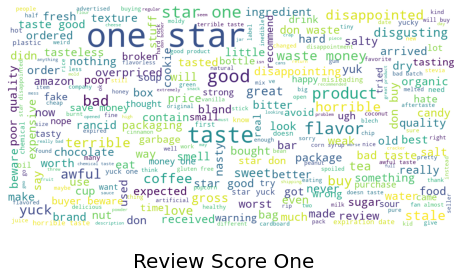

In [ ]:
show_wordcloud(cluster1["summaryClean"][0], title = "Review Score One")

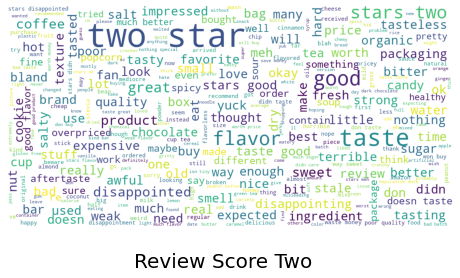

In [ ]:
show_wordcloud(cluster1["summaryClean"][1] , title = "Review Score Two")

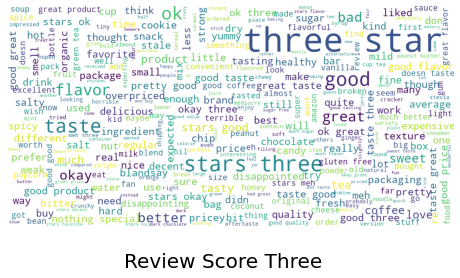

In [ ]:
show_wordcloud(cluster1["summaryClean"][2], title = "Review Score Three")

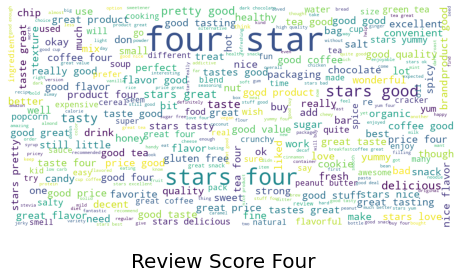

In [ ]:
show_wordcloud(cluster1["summaryClean"][3], title = "Review Score Four")

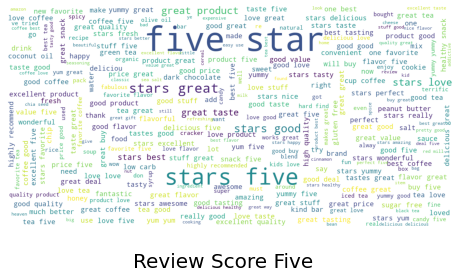

In [ ]:
show_wordcloud(cluster1["summaryClean"][4], title = "Review Score Five")